In [2]:
!pip install PyWavelets
!pip install xgboost
!pip install tensorflow
!pip install scikit-learn
!pip install --upgrade xgboost scikit-learn


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from keras.callbacks import EarlyStopping
import pywt
from scipy.fft import fft
from keras.models import Sequential

In [4]:
file_path= '/content/combined_battery_data.csv'
data=pd.read_csv(file_path, delimiter=',')

In [5]:
data.head()

,Battery_id,Cycle Number,Voltage,Ambient temp,Current,Temperature,Current Load,Voltage Load,Time,Fluctuation Index,...,Kurtosis Index,Capacity,SoC,Discharge Rate,Energy,Battery Voltage Slope,Voltage Range,Battery Impedance,Power,Temperature Deviation
0,5,1,4.191492,24,-0.004902,24.330034,-0.0006,0.000,0.000,0.179017,...,4.309881,1.862443,93.12215,-0.002451,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.242294
1,5,1,4.190749,24,-0.001478,24.325993,-0.0006,4.206,16.781,0.179017,...,4.309881,1.862443,93.12215,-0.000739,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.246335
2,5,1,3.974871,24,-2.012528,24.389085,-1.9982,3.062,35.703,0.179017,...,4.309881,1.862443,93.12215,-1.006264,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.183243
3,5,1,3.951717,24,-2.013979,24.544752,-1.9982,3.030,53.781,0.179017,...,4.309881,1.862443,93.12215,-1.006990,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.027576
4,5,1,3.934352,24,-2.011144,24.731385,-1.9982,3.011,71.922,0.179017,...,4.309881,1.862443,93.12215,-1.005572,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-7.840943


In [6]:
data.tail()

,Battery_id,Cycle Number,Voltage,Ambient temp,Current,Temperature,Current Load,Voltage Load,Time,Fluctuation Index,...,Kurtosis Index,Capacity,SoC,Discharge Rate,Energy,Battery Voltage Slope,Voltage Range,Battery Impedance,Power,Temperature Deviation
770065,56,102,3.722741,4,-0.002669,11.432024,0.0004,0.0,2304.750,0.212975,...,2.772364,1.132478,56.623884,-0.001335,-1.132478,-0.000192,1.486864,-6672.187,-5.667507,0.979276
770066,56,102,3.724128,4,-0.003104,11.310875,0.0006,0.0,2317.984,0.212975,...,2.772364,1.132478,56.623884,-0.001552,-1.132478,-0.000192,1.486864,-6672.187,-5.667507,0.858127
770067,56,102,3.725061,4,-0.001345,11.176975,0.0004,0.0,2331.187,0.212975,...,2.772364,1.132478,56.623884,-0.000673,-1.132478,-0.000192,1.486864,-6672.187,-5.667507,0.724226
770068,56,102,3.726110,4,0.000979,11.037694,0.0004,0.0,2344.468,0.212975,...,2.772364,1.132478,56.623884,0.000490,-1.132478,-0.000192,1.486864,-6672.187,-5.667507,0.584946
770069,56,102,3.727256,4,-0.000989,10.855559,0.0004,0.0,2357.687,0.212975,...,2.772364,1.132478,56.623884,-0.000494,-1.132478,-0.000192,1.486864,-6672.187,-5.667507,0.402811


In [7]:
data.shape

(770070, 21)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770070 entries, 0 to 770069
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Battery_id             770070 non-null  int64  
 1   Cycle Number           770070 non-null  int64  
 2   Voltage                770070 non-null  float64
 3   Ambient temp           770070 non-null  int64  
 4   Current                770070 non-null  float64
 5   Temperature            770070 non-null  float64
 6   Current Load           770070 non-null  float64
 7   Voltage Load           770070 non-null  float64
 8   Time                   770070 non-null  float64
 9   Fluctuation Index      770070 non-null  float64
 10  Skewness Index         770070 non-null  float64
 11  Kurtosis Index         770070 non-null  float64
 12  Capacity               770070 non-null  float64
 13  SoC                    770070 non-null  float64
 14  Discharge Rate         770070 non-nu

In [9]:
data.describe()

,Battery_id,Cycle Number,Voltage,Ambient temp,Current,Temperature,Current Load,Voltage Load,Time,Fluctuation Index,...,Kurtosis Index,Capacity,SoC,Discharge Rate,Energy,Battery Voltage Slope,Voltage Range,Battery Impedance,Power,Temperature Deviation
count,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,...,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,7.700700e+05
mean,32.748683,56.180995,3.417351,19.327648,-1.578464,27.281331,1.487260,2.015373,1883.618060,0.274227,...,4.946644,1.478739,73.936971,-0.789232,-1.478739,-0.000137,1.848357,-332.271430,-5.283510,3.346629e-17
std,15.910368,46.851345,0.419136,12.332820,1.161964,14.062328,1.268142,1.134413,1390.592695,0.074246,...,2.734331,0.351855,17.592731,0.580982,0.351855,0.000297,0.339587,5537.971446,2.205411,4.152157e+00
min,5.000000,1.000000,0.192738,4.000000,-4.038796,2.904756,-2.000000,0.000000,0.000000,0.000103,...,1.221042,-0.002425,-0.121238,-2.019398,-3.024383,-0.022194,0.001614,-169024.758010,-13.472789,-2.163345e+01
25%,25.000000,19.000000,3.282026,4.000000,-2.010765,11.462661,0.998000,1.304000,795.047000,0.221793,...,3.486263,1.311085,65.554238,-1.005382,-1.737177,-0.000233,1.559900,-494.714029,-6.527487,-2.107441e+00
50%,36.000000,41.000000,3.473762,24.000000,-1.989172,30.083127,1.998000,2.431000,1639.781000,0.267677,...,4.366963,1.533216,76.660788,-0.994586,-1.533216,-0.000189,1.787652,-78.242966,-5.583059,-7.086315e-02
75%,45.000000,88.000000,3.664314,24.000000,-0.995509,36.023366,1.999000,2.776000,2620.781000,0.329369,...,5.285611,1.737177,86.858857,-0.497754,-1.311085,-0.000078,2.092426,-9.160808,-3.480186,2.090297e+00
max,56.000000,197.000000,4.542427,44.000000,0.030461,69.869746,4.148800,97.000000,6574.671000,0.996250,...,47.022046,3.024383,151.219132,0.015231,0.002425,0.001355,4.186368,53295.490673,0.000584,2.138382e+01


In [10]:
data=data.dropna()
missing_values=data.isnull().sum()
print(missing_values[missing_values>0])

Series([], dtype: int64)


In [11]:
duplicates=data.duplicated()
print(data[duplicates])

Empty DataFrame
Columns: [Battery_id, Cycle Number, Voltage, Ambient temp, Current, Temperature, Current Load, Voltage Load, Time, Fluctuation Index, Skewness Index, Kurtosis Index, Capacity, SoC, Discharge Rate, Energy, Battery Voltage Slope, Voltage Range, Battery Impedance, Power, Temperature Deviation]
Index: []

[0 rows x 21 columns]


In [12]:
data = data.drop(columns=['SoC'])

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770070 entries, 0 to 770069
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Battery_id             770070 non-null  int64  
 1   Cycle Number           770070 non-null  int64  
 2   Voltage                770070 non-null  float64
 3   Ambient temp           770070 non-null  int64  
 4   Current                770070 non-null  float64
 5   Temperature            770070 non-null  float64
 6   Current Load           770070 non-null  float64
 7   Voltage Load           770070 non-null  float64
 8   Time                   770070 non-null  float64
 9   Fluctuation Index      770070 non-null  float64
 10  Skewness Index         770070 non-null  float64
 11  Kurtosis Index         770070 non-null  float64
 12  Capacity               770070 non-null  float64
 13  Discharge Rate         770070 non-null  float64
 14  Energy                 770070 non-nu

In [14]:
data['SoC'] = data['Capacity'] / data.groupby('Battery_id')['Capacity'].transform('max') * 100


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770070 entries, 0 to 770069
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Battery_id             770070 non-null  int64  
 1   Cycle Number           770070 non-null  int64  
 2   Voltage                770070 non-null  float64
 3   Ambient temp           770070 non-null  int64  
 4   Current                770070 non-null  float64
 5   Temperature            770070 non-null  float64
 6   Current Load           770070 non-null  float64
 7   Voltage Load           770070 non-null  float64
 8   Time                   770070 non-null  float64
 9   Fluctuation Index      770070 non-null  float64
 10  Skewness Index         770070 non-null  float64
 11  Kurtosis Index         770070 non-null  float64
 12  Capacity               770070 non-null  float64
 13  Discharge Rate         770070 non-null  float64
 14  Energy                 770070 non-nu

In [16]:
data.describe()

,Battery_id,Cycle Number,Voltage,Ambient temp,Current,Temperature,Current Load,Voltage Load,Time,Fluctuation Index,...,Kurtosis Index,Capacity,Discharge Rate,Energy,Battery Voltage Slope,Voltage Range,Battery Impedance,Power,Temperature Deviation,SoC
count,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,...,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,7.700700e+05,770070.000000
mean,32.748683,56.180995,3.417351,19.327648,-1.578464,27.281331,1.487260,2.015373,1883.618060,0.274227,...,4.946644,1.478739,-0.789232,-1.478739,-0.000137,1.848357,-332.271430,-5.283510,3.346629e-17,81.274582
std,15.910368,46.851345,0.419136,12.332820,1.161964,14.062328,1.268142,1.134413,1390.592695,0.074246,...,2.734331,0.351855,0.580982,0.351855,0.000297,0.339587,5537.971446,2.205411,4.152157e+00,17.482998
min,5.000000,1.000000,0.192738,4.000000,-4.038796,2.904756,-2.000000,0.000000,0.000000,0.000103,...,1.221042,-0.002425,-2.019398,-3.024383,-0.022194,0.001614,-169024.758010,-13.472789,-2.163345e+01,-0.170647
25%,25.000000,19.000000,3.282026,4.000000,-2.010765,11.462661,0.998000,1.304000,795.047000,0.221793,...,3.486263,1.311085,-1.005382,-1.737177,-0.000233,1.559900,-494.714029,-6.527487,-2.107441e+00,73.989337
50%,36.000000,41.000000,3.473762,24.000000,-1.989172,30.083127,1.998000,2.431000,1639.781000,0.267677,...,4.366963,1.533216,-0.994586,-1.533216,-0.000189,1.787652,-78.242966,-5.583059,-7.086315e-02,83.574317
75%,45.000000,88.000000,3.664314,24.000000,-0.995509,36.023366,1.999000,2.776000,2620.781000,0.329369,...,5.285611,1.737177,-0.497754,-1.311085,-0.000078,2.092426,-9.160808,-3.480186,2.090297e+00,94.209026
max,56.000000,197.000000,4.542427,44.000000,0.030461,69.869746,4.148800,97.000000,6574.671000,0.996250,...,47.022046,3.024383,0.015231,0.002425,0.001355,4.186368,53295.490673,0.000584,2.138382e+01,100.000000


In [17]:
data.head()

,Battery_id,Cycle Number,Voltage,Ambient temp,Current,Temperature,Current Load,Voltage Load,Time,Fluctuation Index,...,Kurtosis Index,Capacity,Discharge Rate,Energy,Battery Voltage Slope,Voltage Range,Battery Impedance,Power,Temperature Deviation,SoC
0,5,1,4.191492,24,-0.004902,24.330034,-0.0006,0.000,0.000,0.179017,...,4.309881,1.862443,-0.002451,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.242294,100.0
1,5,1,4.190749,24,-0.001478,24.325993,-0.0006,4.206,16.781,0.179017,...,4.309881,1.862443,-0.000739,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.246335,100.0
2,5,1,3.974871,24,-2.012528,24.389085,-1.9982,3.062,35.703,0.179017,...,4.309881,1.862443,-1.006264,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.183243,100.0
3,5,1,3.951717,24,-2.013979,24.544752,-1.9982,3.030,53.781,0.179017,...,4.309881,1.862443,-1.006990,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.027576,100.0
4,5,1,3.934352,24,-2.011144,24.731385,-1.9982,3.011,71.922,0.179017,...,4.309881,1.862443,-1.005572,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-7.840943,100.0


In [18]:
columns_to_compare = ['Battery_id', 'Cycle Number', 'Voltage', 'Ambient temp', 'Current',
       'Temperature', 'Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
        'Discharge Rate', 'Energy', 'Battery Voltage Slope',
       'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation']
for column in columns_to_compare:
    correlation = data[column].corr(data['SoC'])
    print(f'Correlation coefficient between {column} and SoC: {correlation:.2f}')

Correlation coefficient between Battery_id and SoC: -0.14
Correlation coefficient between Cycle Number and SoC: -0.29
Correlation coefficient between Voltage and SoC: 0.22
Correlation coefficient between Ambient temp and SoC: 0.39
Correlation coefficient between Current and SoC: -0.13
Correlation coefficient between Temperature and SoC: 0.36
Correlation coefficient between Current Load and SoC: 0.06
Correlation coefficient between Voltage Load and SoC: 0.28
Correlation coefficient between Time and SoC: 0.23
Correlation coefficient between Fluctuation Index and SoC: 0.24
Correlation coefficient between Skewness Index and SoC: 0.21
Correlation coefficient between Kurtosis Index and SoC: -0.16
Correlation coefficient between Capacity and SoC: 0.81
Correlation coefficient between Discharge Rate and SoC: -0.13
Correlation coefficient between Energy and SoC: -0.81
Correlation coefficient between Battery Voltage Slope and SoC: -0.21
Correlation coefficient between Voltage Range and SoC: 0.16


In [19]:
data.columns

Index(['Battery_id', 'Cycle Number', 'Voltage', 'Ambient temp', 'Current',
       'Temperature', 'Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
       'Discharge Rate', 'Energy', 'Battery Voltage Slope', 'Voltage Range',
       'Battery Impedance', 'Power', 'Temperature Deviation', 'SoC'],
      dtype='object')

In [41]:
from xgboost import XGBRegressor

In [42]:
data.shape

(770070, 21)

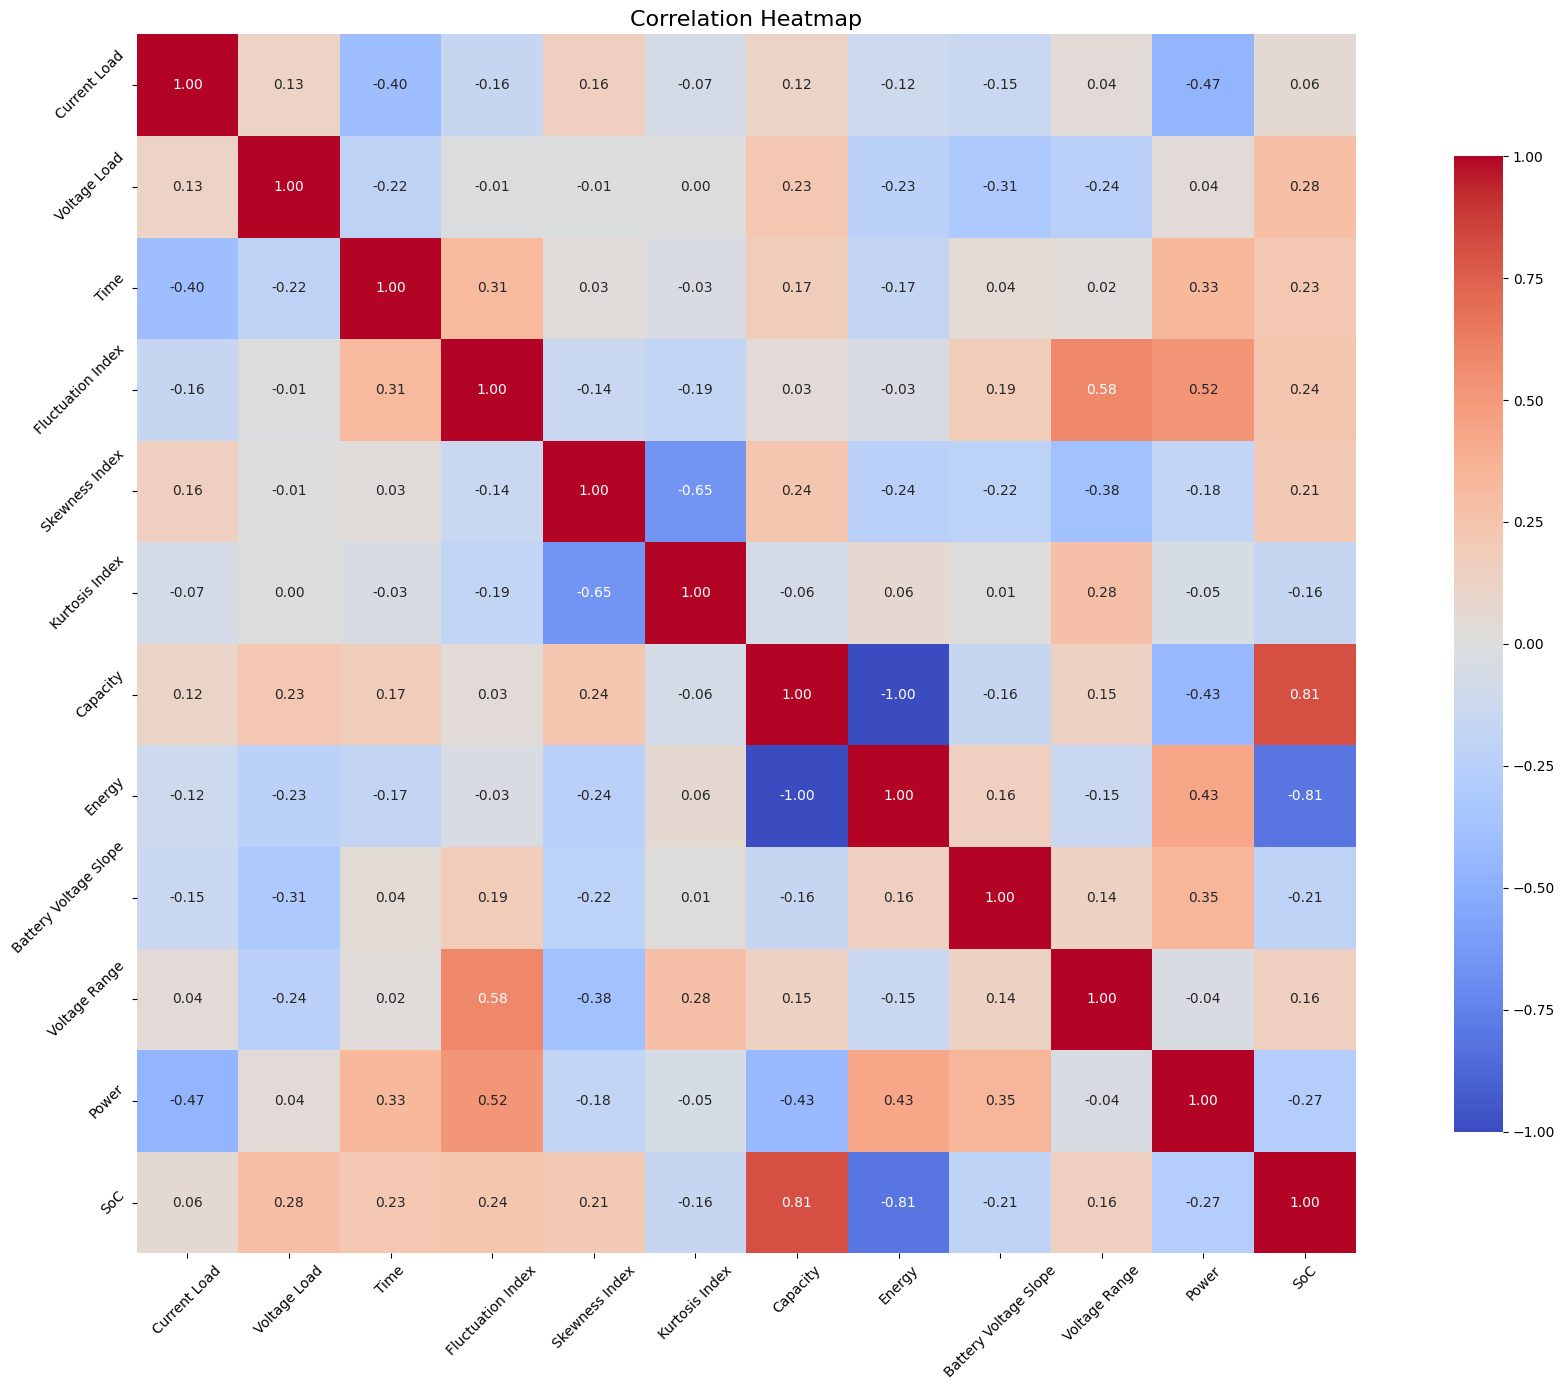

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
# Replace with your actual data loading process
# data = pd.read_csv('your_battery_data.csv')

# Prepare your input features
input_data = data[['Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
        'Energy', 'Battery Voltage Slope',
       'Voltage Range',  'Power', 'SoC']]

# Calculate the correlation matrix
correlation_matrix = input_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 14))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Add title and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

**CNN + XGB**

Epoch 1/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 541.3396 - mae: 10.5758
Epoch 2/15


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


12033/12033 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 222.9743 - mae: 4.1620
Epoch 3/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 220.7609 - mae: 3.8710
Epoch 4/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 219.9399 - mae: 3.7270
Epoch 5/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 219.3694 - mae: 3.6270
Epoch 6/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 219.1108 - mae: 3.5634
Epoch 7/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 218.9123 - mae: 3.5251
Epoch 8/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 218.5174 - mae: 3.4597
Epoch 9/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 218.3143 - mae: 3.4320
Epoch 10/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 218.2338 - mae: 3.4008
Epoch 11/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 218.2498 - mae: 3.3950
Epoch 12/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 218.0512 - mae: 3.3999
Epoch 13/15
12033/12033 ━━━━━━━━━━━━━━━━

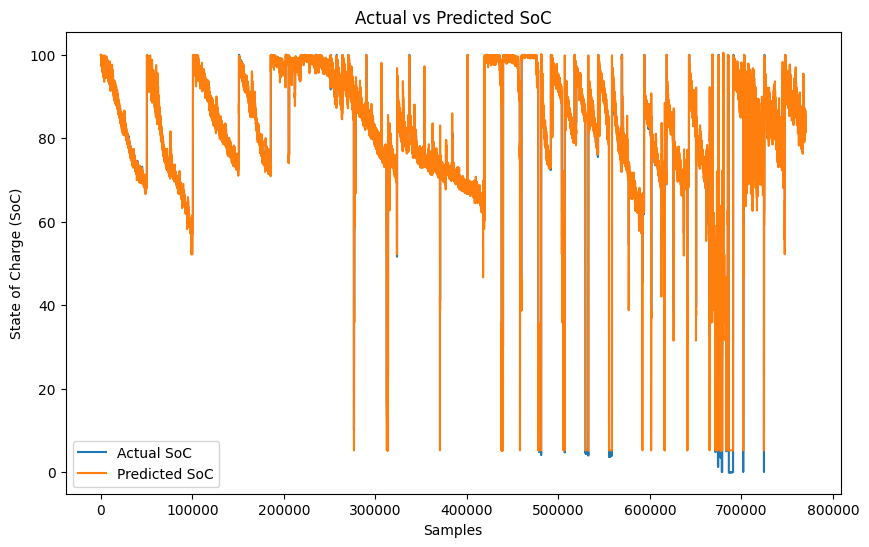

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'data' is already loaded and preprocessed
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power',
            'Temperature Deviation', 'Time']

# Replace 'RUL' with 'SoC'
X = data[features].values
y = data['SoC'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Number of time steps for sequence creation
time_steps = 10

# Function to create sequences
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(time_steps, X_seq.shape[2])),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
])

cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train CNN model
cnn_model.fit(X_seq, y_seq, epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1)

# Extract CNN features for XGBoost
X_cnn_features = cnn_model.predict(X_seq)

# Train XGBoost model on CNN features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(X_cnn_features, y_seq)

# Predict SoC
y_pred = xgb_model.predict(X_cnn_features)

# Evaluating the performance
mae = mean_absolute_error(y_seq, y_pred)
mse = mean_squared_error(y_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_seq, y_pred)

# Print evaluation metrics
print(f'Mean Absolute Error (MAE) for SoC prediction: {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

# Actual vs predicted SoC plot
plt.figure(figsize=(10, 6))
plt.plot(y_seq, label='Actual SoC')
plt.plot(y_pred, label='Predicted SoC')
plt.title('Actual vs Predicted SoC')
plt.xlabel('Samples')
plt.ylabel('State of Charge (SoC)')
plt.legend()
plt.show()


Epoch 1/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 832.3810 - mae: 14.5606 - val_loss: 336.1423 - val_mae: 5.9179
Epoch 2/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 334.6091 - mae: 5.7898 - val_loss: 330.1309 - val_mae: 5.2379
Epoch 3/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 330.5852 - mae: 5.3274 - val_loss: 328.9073 - val_mae: 5.0929
Epoch 4/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 329.1817 - mae: 5.1360 - val_loss: 328.2113 - val_mae: 5.0041
Epoch 5/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 328.4060 - mae: 5.0401 - val_loss: 327.5330 - val_mae: 4.8895
Epoch 6/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 327.6872 - mae: 4.9637 - val_loss: 326.9372 - val_mae: 4.7323
Epoch 7/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 328.0002 - mae: 4.9332 - val_loss: 327.5123 - val_mae: 4.9257
Epoch 8/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 327.7572 - mae: 4.9043 - val_loss: 327.3891 - val_mae: 4.9265

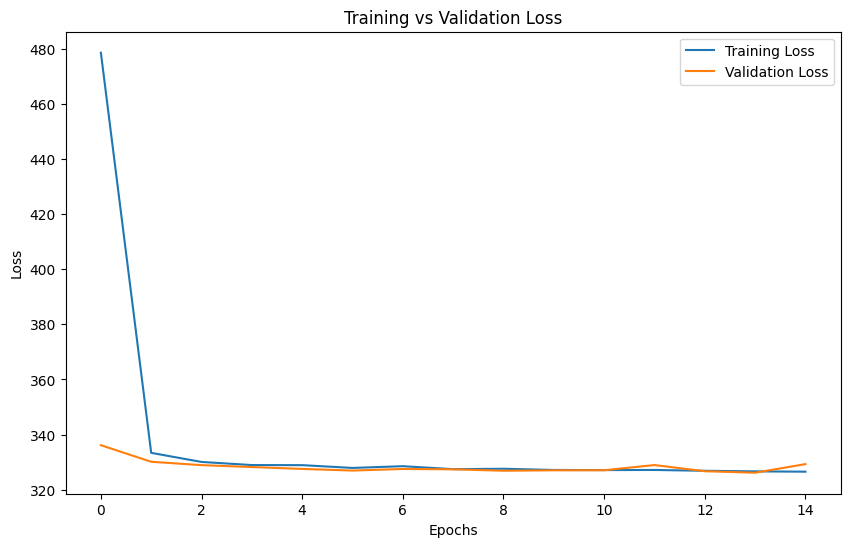

16846/16846 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
3610/3610 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
3610/3610 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Validation Set Metrics:
Mean Absolute Error (MAE): 0.8067921981643178
Mean Squared Error (MSE): 2.237488087397901
Root Mean Squared Error (RMSE): 1.4958235482161326
R² (Coefficient of Determination): 0.9926119164258047
Test Set Metrics:
Mean Absolute Error (MAE): 0.8098438361213461
Mean Squared Error (MSE): 2.2447672379460486
Root Mean Squared Error (RMSE): 1.4982547306603269
R² (Coefficient of Determination): 0.992620440461555


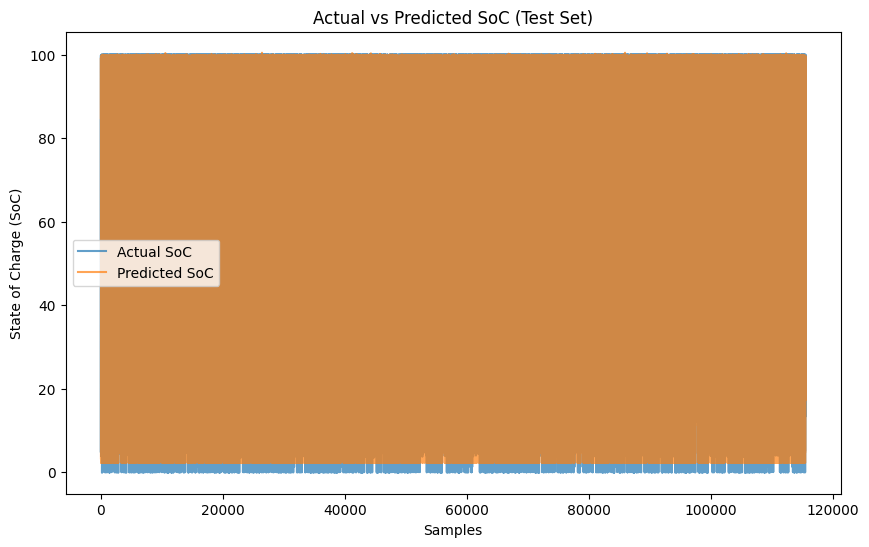

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to create sequences
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']

X = data[features].values
y = data['SoC'].values  # Change target to SoC

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Number of time steps for sequence creation
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# CNN model
cnn_model = models.Sequential([
    Input(shape=(time_steps, X_seq.shape[2])),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Flatten(),  # Ensure the output is 1D
    layers.Dense(64, activation='relu'),
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the CNN model
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Extract CNN features from the training, validation, and test sets
X_train_cnn = cnn_model.predict(X_train)
X_val_cnn = cnn_model.predict(X_val)
X_test_cnn = cnn_model.predict(X_test)

# Train XGBoost model on CNN-extracted training features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(X_train_cnn, y_train)

# Evaluate on validation and test sets to check for overfitting
y_val_pred = xgb_model.predict(X_val_cnn)
y_test_pred = xgb_model.predict(X_test_cnn)

# Metrics for validation set
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Set Metrics:')
print(f'Mean Absolute Error (MAE): {val_mae}')
print(f'Mean Squared Error (MSE): {val_mse}')
print(f'Root Mean Squared Error (RMSE): {val_rmse}')
print(f'R² (Coefficient of Determination): {val_r2}')

# Metrics for test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Set Metrics:')
print(f'Mean Absolute Error (MAE): {test_mae}')
print(f'Mean Squared Error (MSE): {test_mse}')
print(f'Root Mean Squared Error (RMSE): {test_rmse}')
print(f'R² (Coefficient of Determination): {test_r2}')

# Plot actual vs predicted SoC for test set
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual SoC', alpha=0.7)
plt.plot(y_test_pred, label='Predicted SoC', alpha=0.7)
plt.title('Actual vs Predicted SoC (Test Set)')
plt.xlabel('Samples')
plt.ylabel('State of Charge (SoC)')
plt.legend()
plt.show()


**CNN + BI LSTM**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 609s 31ms/step - loss: 178.7982 - mae: 9.3486 - val_loss: 159.2350 - val_mae: 6.9662 - learning_rate: 0.0010
Epoch 2/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 619s 31ms/step - loss: 58.3334 - mae: 6.0019 - val_loss: 126.8125 - val_mae: 5.9077 - learning_rate: 0.0010
Epoch 3/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 619s 31ms/step - loss: 49.3188 - mae: 5.5079 - val_loss: 134.3205 - val_mae: 7.3297 - learning_rate: 0.0010
Epoch 4/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 618s 31ms/step - loss: 41.6758 - mae: 5.0516 - val_loss: 125.9603 - val_mae: 6.3494 - learning_rate: 0.0010
Epoch 5/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 620s 31ms/step - loss: 36.4306 - mae: 4.7026 - val_loss: 162.1969 - val_mae: 7.9228 - learning_rate: 0.0010
Epoch 6/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 624s 31ms/step - loss: 30.8445 - mae: 4.3207 - val_loss: 168.6928 - val_mae: 6.7329 - learning_rate: 0.0010
Epoch 7/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 591s 31ms/step - loss: 26.5473 - mae: 3.965

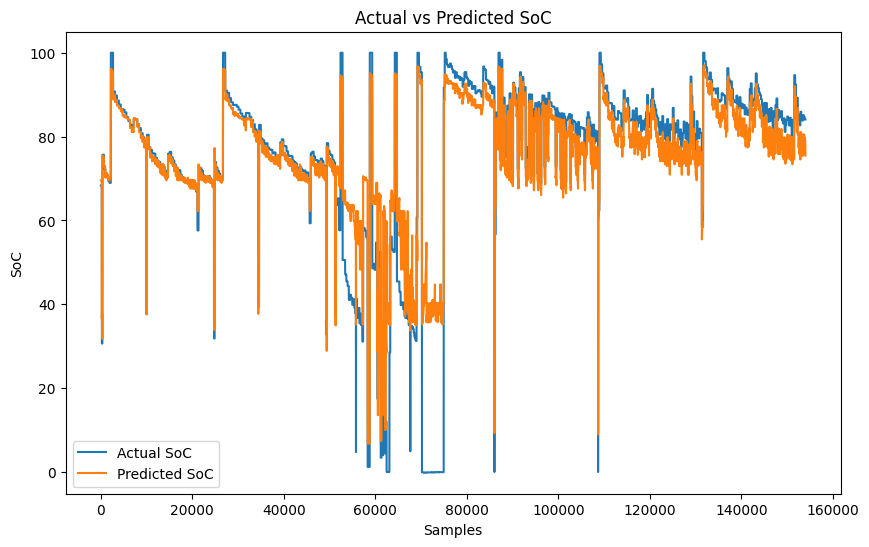

In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'data' is already loaded and preprocessed
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power',
            'Temperature Deviation', 'Time']

# Replace 'RUL' with 'SoC'
X = data[features].values
y = data['SoC'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Number of time steps for sequence creation
time_steps = 10
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Function to create sequences for time-series data
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Extract features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values

y = data['SoC'].values  # State of Charge (SoC) is now the target variable

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define time steps and create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# Split into training and validation sets
train_size = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:train_size], X_seq[train_size:]
y_train, y_val = y_seq[:train_size], y_seq[train_size:]

# Build the model with improved architecture
model = models.Sequential()

# CNN Layer 1
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(0.4))

# CNN Layer 2
model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(layers.Dropout(0.4))

# CNN Layer 3
model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))
model.add(layers.Dropout(0.4))

# Bidirectional LSTM Layer
model.add(layers.Bidirectional(layers.LSTM(100, return_sequences=False)))
model.add(layers.Dropout(0.5))

# Dense Layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))

# Output Layer
model.add(layers.Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks for learning rate adjustment and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# Evaluate the model
loss, mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Final Model - MAE: {mae}")

# Predict with the model
y_pred = model.predict(X_val)

# Evaluate the model performance
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

# Plot actual vs predicted SoC
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual SoC')
plt.plot(y_pred, label='Predicted SoC')
plt.title('Actual vs Predicted SoC')
plt.xlabel('Samples')
plt.ylabel('SoC')
plt.legend()
plt.show()


**CNN + BI DIRECTIONAL LSTM + XGB**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 289s 15ms/step - loss: 246.5123 - mae: 10.5898 - val_loss: 129.1840 - val_mae: 6.7076 - learning_rate: 0.0010
Epoch 2/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 325s 15ms/step - loss: 61.6720 - mae: 6.1686 - val_loss: 98.5387 - val_mae: 5.0596 - learning_rate: 0.0010
Epoch 3/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 295s 15ms/step - loss: 46.7987 - mae: 5.3667 - val_loss: 76.8439 - val_mae: 4.0268 - learning_rate: 0.0010
Epoch 4/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 307s 15ms/step - loss: 36.3248 - mae: 4.7101 - val_loss: 91.0088 - val_mae: 4.3004 - learning_rate: 0.0010
Epoch 5/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 341s 16ms/step - loss: 27.8509 - mae: 4.1081 - val_loss: 112.5756 - val_mae: 4.5148 - learning_rate: 0.0010
Epoch 6/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 322s 16ms/step - loss: 21.4877 - mae: 3.5843 - val_loss: 106.5290 - val_mae: 4.4382 - learning_rate: 5.0000e-04
Epoch 7/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 301s 14ms/step - loss: 18.2780 - mae: 3.2

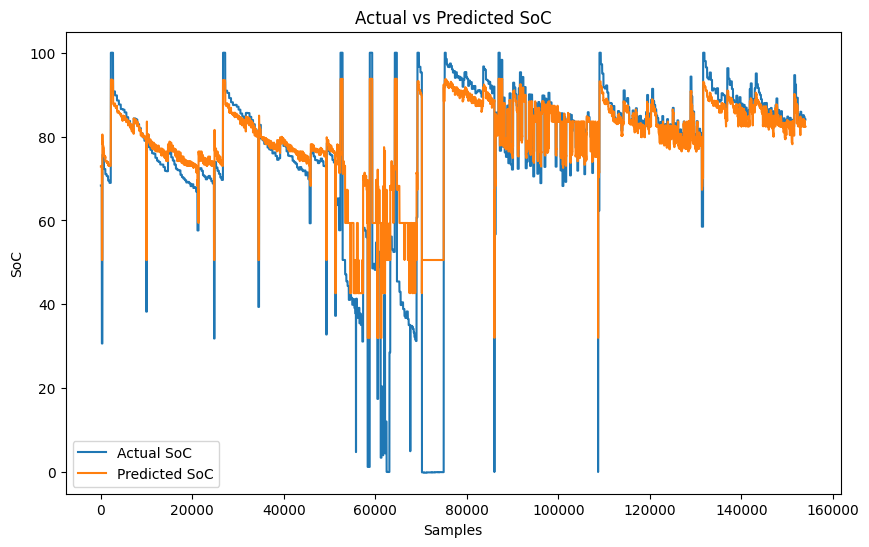

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Function to create sequences for time-series data
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])  # Use the SoC of the last time step in the sequence
    return np.array(X), np.array(y)

# Extract features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values
y = data['SoC'].values  # State of Charge (SoC) is the target variable

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define time steps and create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# Split into training and validation sets
train_size = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:train_size], X_seq[train_size:]
y_train, y_val = y_seq[:train_size], y_seq[train_size:]

# Build CNN-LSTM model with 2 CNN layers and reduced LSTM units
cnn_lstm_model = Sequential()

# CNN Layer 1
cnn_lstm_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_lstm_model.add(Dropout(0.3))  # Reduced dropout rate

# CNN Layer 2
cnn_lstm_model.add(Conv1D(128, kernel_size=3, activation='relu'))
cnn_lstm_model.add(Dropout(0.3))  # Reduced dropout rate

# Bidirectional LSTM Layer with fewer units
cnn_lstm_model.add(Bidirectional(LSTM(50, return_sequences=False)))  # Reduced units
cnn_lstm_model.add(Dropout(0.4))

# Dense Layer
cnn_lstm_model.add(Dense(64, activation='relu'))  # Reduced units
cnn_lstm_model.add(Dropout(0.3))  # Reduced dropout rate

# Output Layer
cnn_lstm_model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
cnn_lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks for learning rate adjustment and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)  # Reduced patience
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Reduced patience

# Train the CNN-LSTM model
cnn_lstm_model.fit(
    X_train, y_train,
    epochs=15,  # Reduced epochs
    batch_size=32,  # Kept batch size
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# Extract CNN features
cnn_features_train = cnn_lstm_model.predict(X_train)
cnn_features_val = cnn_lstm_model.predict(X_val)

# Reshape the CNN features to be used by XGBoost
cnn_features_train_reshaped = cnn_features_train.reshape(cnn_features_train.shape[0], -1)
cnn_features_val_reshaped = cnn_features_val.reshape(cnn_features_val.shape[0], -1)

# Train the XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=10)

xg_reg.fit(cnn_features_train_reshaped, y_train)

# Predict with XGBoost model
y_pred_xgboost = xg_reg.predict(cnn_features_val_reshaped)

# Evaluate the model performance
mse = mean_squared_error(y_val, y_pred_xgboost)
mae = mean_absolute_error(y_val, y_pred_xgboost)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_xgboost)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

# Plot actual vs predicted SoC
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual SoC')
plt.plot(y_pred_xgboost, label='Predicted SoC')
plt.title('Actual vs Predicted SoC')
plt.xlabel('Samples')
plt.ylabel('SoC')
plt.legend()
plt.show()


**CNN + LSTM + XGB**

Epoch 1/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 68s 5ms/step - loss: 1646.6418 - mae: 27.9121
Epoch 2/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 109.6946 - mae: 2.0195
Epoch 3/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 108.7415 - mae: 1.7779
Epoch 4/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 19.3553 - mae: 0.8024
Epoch 5/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - loss: 0.4375 - mae: 0.3758
Epoch 6/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - loss: 0.3825 - mae: 0.3429
Epoch 7/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 0.2890 - mae: 0.2956
Epoch 8/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.2312 - mae: 0.2706
Epoch 9/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/step - loss: 0.2443 - mae: 0.2613
Epoch 10/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - loss: 0.2047 - mae: 0.2486
Epoch 11/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - loss: 0.1874 - mae: 0.2298
Epoch 12/15
12033/12033 ━━━━━━━━━━━━━━━━━━━

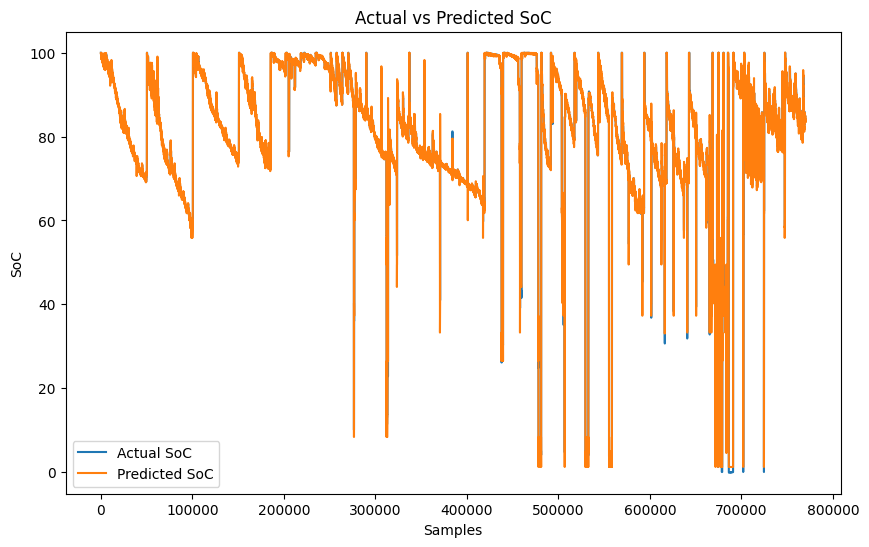

In [48]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Prepare your features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power',
            'Temperature Deviation', 'Time']
X = data[features].values

y = data['SoC'].values  # Predicting SoC (State of Charge) instead of RUL

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define sequence length
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# CNN-LSTM Model
cnn_lstm_model = Sequential([
    layers.Input(shape=(time_steps, X_seq.shape[2])),

    # CNN layers
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),

    # LSTM layer
    layers.LSTM(64, return_sequences=False),

    # Dense layer to flatten output for XGBoost
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
])

cnn_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model
#early_stopping = layers.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
#cnn_lstm_model.fit(X_seq, y_seq, epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1)

from keras.callbacks import EarlyStopping  # Correct import

# Fit the model
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
cnn_lstm_model.fit(X_seq, y_seq, epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1)


# Extract CNN-LSTM features for XGBoost
X_cnn_lstm_features = cnn_lstm_model.predict(X_seq)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(X_cnn_lstm_features, y_seq)

# Predict SoC
y_pred = xgb_model.predict(X_cnn_lstm_features)

# Evaluate model
mae = mean_absolute_error(y_seq, y_pred)
mse = mean_squared_error(y_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_seq, y_pred)

print(f'Mean Absolute Error (MAE) for SoC prediction: {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

# Plot Actual vs Predicted SoC
plt.figure(figsize=(10, 6))
plt.plot(y_seq, label='Actual SoC')
plt.plot(y_pred, label='Predicted SoC')
plt.title('Actual vs Predicted SoC')
plt.xlabel('Samples')
plt.ylabel('SoC')
plt.legend()
plt.show()


**RNN + XGB**

24065/24065 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step
Mean Absolute Error (MAE) for SoC prediction: 0.4883038483868458
Mean Squared Error (MSE): 0.5095062217479941
Root Mean Squared Error (RMSE): 0.713797045208226
R² (Coefficient of Determination): 0.9983330659354405


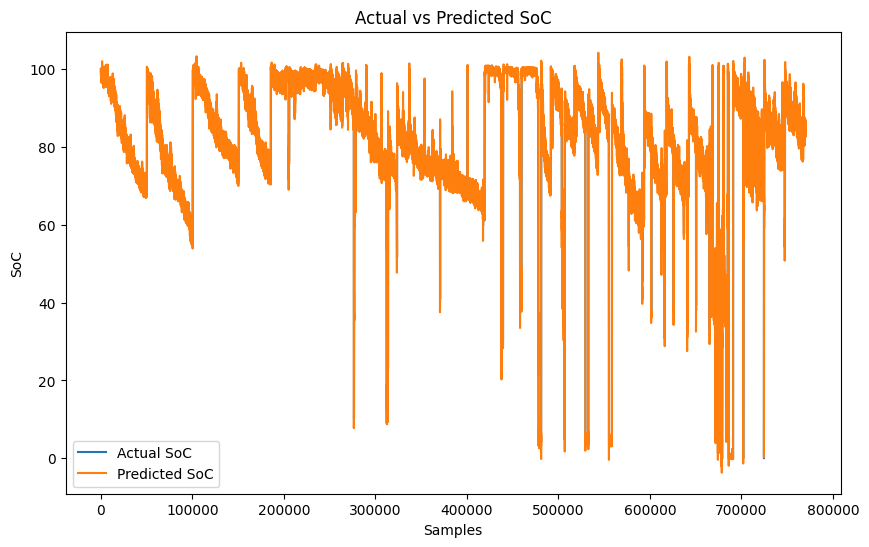

In [51]:
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# Function to create sequences for time-series prediction
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Feature extraction using RNN
def extract_rnn_features(X_seq):
    # Define RNN Model
    rnn_model = Sequential([
        layers.Input(shape=(X_seq.shape[1], X_seq.shape[2])),  # Input shape
        layers.SimpleRNN(64, activation='relu', return_sequences=False),  # RNN layer
        layers.Dense(32, activation='relu'),  # Dense layer to extract features
    ])

    # Extract features
    rnn_features = rnn_model.predict(X_seq)
    return rnn_features

# Assuming `data` is your DataFrame containing the features like Voltage, Current, etc.
features = ['Voltage', 'Current', 'Temperature', 'Capacity', 'SoC', 'Discharge Rate', 'Energy']
X = data[features].values
y = data['SoC'].values  # Target variable: State of Charge (SoC)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define sequence length
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)

# Extract RNN features
rnn_features = extract_rnn_features(X_seq)

# Train XGBoost model on the extracted RNN features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(rnn_features, y_seq)  # Train with RNN features

# Predict SoC using XGBoost
y_pred = xgb_model.predict(rnn_features)

# Evaluate model
mae = mean_absolute_error(y_seq, y_pred)
mse = mean_squared_error(y_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_seq, y_pred)

print(f'Mean Absolute Error (MAE) for SoC prediction: {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

# Plot Actual vs Predicted SoC
plt.figure(figsize=(10, 6))
plt.plot(y_seq, label='Actual SoC')
plt.plot(y_pred, label='Predicted SoC')
plt.title('Actual vs Predicted SoC')
plt.xlabel('Samples')
plt.ylabel('SoC')
plt.legend()
plt.show()
